**PART-A**

* DOMAIN: Digital content management

* CONTEXT: Classification is probably the most popular task that you would deal with in real life. Text in the form of blogs, posts, articles, etc. 
are written every second. It is a challenge to predict the information about the writer without knowing about him/her. We are going to create a 
classifier that predicts multiple features of the author of a given text. We have designed it as a Multi label classification problem.

In [1]:
# mounting google drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
pip install langdetect

In [ ]:
pip install nlpaug

In [ ]:
# importing all the necessary packages

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

from langdetect import detect,detector_factory
detector_factory.seed = 42

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
stopwords = set(stopwords.words('english'))

import json
import nlpaug
import nlpaug.augmenter.word as naw


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

from tensorflow.keras.utils import to_categorical


import warnings
warnings.filterwarnings('ignore')

In [5]:
# storing the data in a dataframe

blog = pd.read_csv("/content/drive/MyDrive/NLP/Wee_3 Assignment/blogtext.csv")
blog.head(5)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [6]:
print("The shape of the dataframe is:",blog.shape)

The shape of the dataframe is: (681284, 7)


In [7]:
# checking the datatype of each column

blog.dtypes

id         int64
gender    object
age        int64
topic     object
sign      object
date      object
text      object
dtype: object

In [8]:
# checking for nulls in the numerical columns

blog.isnull().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

**UNIVARIATE ANALYSIS**

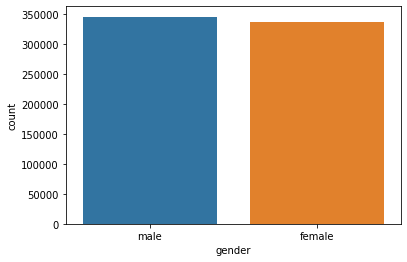

In [9]:
sns.countplot(x = 'gender',data = blog);

* The count of both male and female are almost equal in the dataset

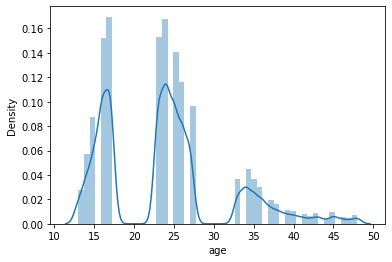

In [10]:
sns.distplot(blog['age'],hist=True);

* The distribution of age is high for values between 15-20 adn 20-30 where there is no blogs written by people of age 20-25 and 30-35. The maximum age is around 50

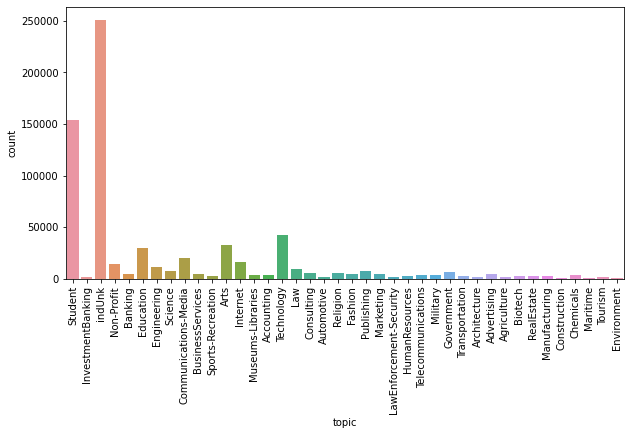

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'topic',data = blog);
plt.xticks(rotation=90)
plt.show()

* We can see that most of the people nearly 250,000 have blogged on indUnk topic followed by 150,000 have blogged on Student. All the other topics share a similar count of around 10,000

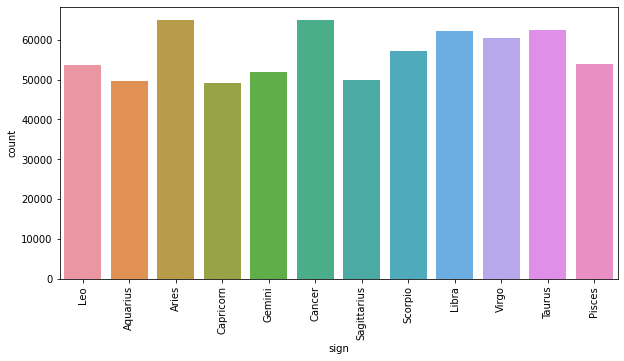

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'sign',data = blog);
plt.xticks(rotation=90)
plt.show()

* The count of zodiac sign of each people is nearly the same in the dataset. Aries and Cancer signs top the group.

**BI-VARIATE ANALYSIS**

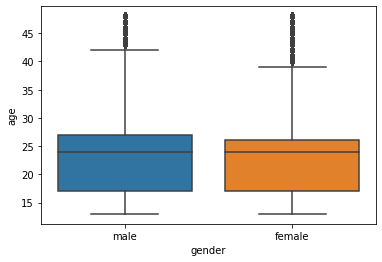

In [13]:
sns.boxplot(x = 'gender',y = 'age',data = blog);

* The mean age of both male and female are 23. The maximum and the minimum age is also the same for both male and female.

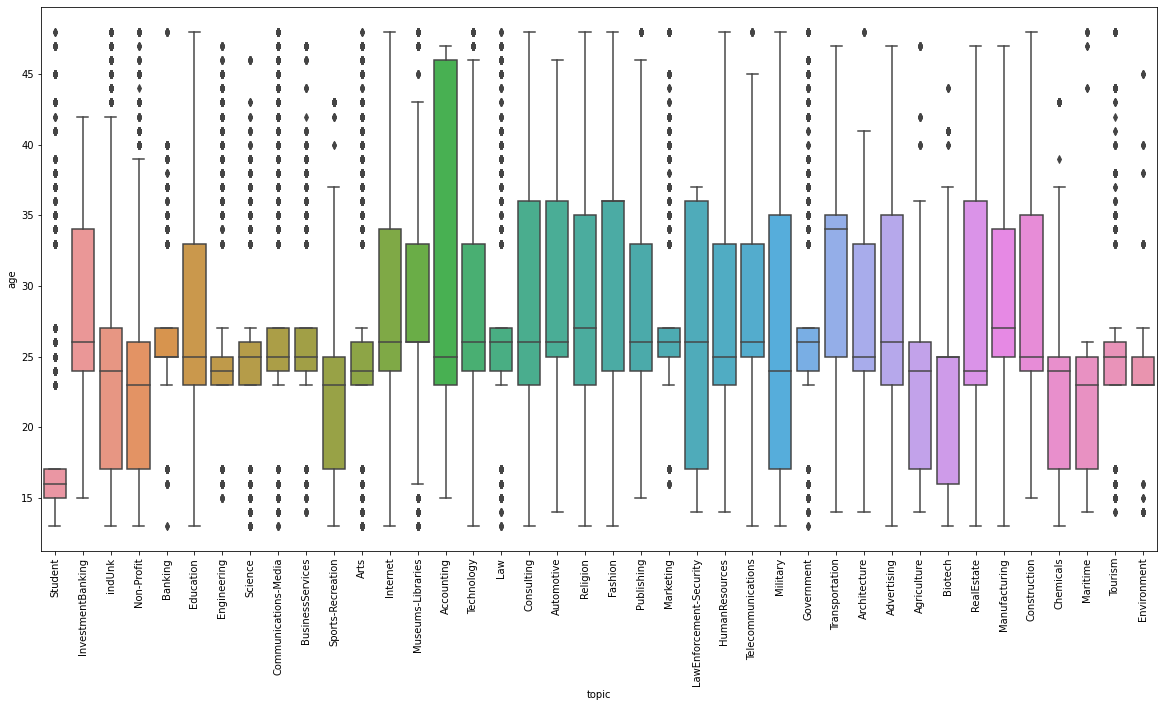

In [14]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'topic',y = 'age',data = blog);
plt.xticks(rotation=90)
plt.show()

* The mean age of all the people who have blogged on different topics is almost the same

* Only the mean of people who have blogged on Student is small compared to others. This might be because almost most the blogs on Student topic is written by student themselves where the age is ranging between 15 and 23. The people above this age might be teacher, letcurers etc




In [15]:
# replacing all the special characters and numbers with empty string

blog['text'] = blog['text'].fillna('').astype(str).str.replace(r'[^A-Za-z ]', '', regex=True).replace('', np.nan, regex=False)

In [16]:
# creating a new dataframe where the column text do not have empty spaces
blog['isspace'] = blog['text'].apply(lambda x: x.isspace())

blog_new = blog[blog['isspace']==False]

We will sample the 7000 records from the dataset as Algorithms such as Logistic Regression, Knn, Langdetect and the vectorizer need enormous RAM space.

In [17]:
# sampling the 7000 records from the huge dataset

blog_sample = blog_new.sample(n=7000,random_state = 2)

In [18]:
# creating a new column to detect the language of each row

blog_sample['textreveiw'] = blog_sample['text'].apply(detect)

In [19]:
# filtering only the english sentences for modelling

blog_english = blog_sample[blog_sample['textreveiw'] == 'en']

In [20]:
# Convert text to lowercase
blog_english.text = blog_english.text.apply(lambda x: x.lower())

# remove the urllink
blog_english.text = blog_english.text.replace(to_replace=r'urllink',value = '',regex=True)

# Strip unwanted spaces
blog_english.text = blog_english.text.apply(lambda x: x.strip())

# remove stop words
blog_english.text = blog_english.text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))


In [21]:
# defining a function to calculate the accuracy, precision and recall

def metrics(model,X_train,y_train,y_test,y_pred):
  print("The training accuracy is:",model.score(X_train,y_train))
  print("The test accuracy is:",accuracy_score(y_test,y_pred))
  print("The precision score is: ",precision_score(y_test,y_pred,average='weighted',labels=np.unique(y_pred)))
  print("The recall score is: ",recall_score(y_test,y_pred,average='weighted',labels=np.unique(y_pred)))

In [22]:
# splitting the data into dependent and independent variable

X  = blog_english['text']
y = blog_english['topic']

In [23]:
# splitting the data into train and test set

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state=2)

In [24]:
# transforming X_train and X_test using bi-grams

vectorizer = CountVectorizer(ngram_range=(1, 2))
vectorizer.fit(X)
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [25]:
# transforming X_train and X_test using count vectorizer with max feature 5000

vectorizer_5000 = CountVectorizer(max_features=5000)
vectorizer_5000.fit(X)
X_train_5k = vectorizer_5000.transform(X_train)
X_test_5k = vectorizer_5000.transform(X_test)

In [26]:
# transforming the data using glove 300D vectors

embeddings_index_prj1 = {}
glove = open('/content/drive/MyDrive/NLP/Wee_3 Assignment/glove.6B.300d.txt')
for line in glove:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index_prj1[word] = coefs
glove.close()

def sentence_to_words(comp):
    
    words = RegexpTokenizer('\w+').tokenize(comp)
    
    return words

data_list = list()
for comp in blog_english.text:
    sentence = np.zeros(300)
    count = 0
    for w in sentence_to_words(comp):
        try:
            sentence += embeddings_index_prj1[w]
            count += 1
        except KeyError:
            continue
    data_list.append(sentence / count)

In [27]:
# transforming X_train and X_test using TF-IDF vectorizer

tf_idf = TfidfVectorizer(max_features=5000)
tf_idf.fit(X)
X_train_tf = tf_idf.transform(X_train)
X_test_tf = tf_idf.transform(X_test)

In [28]:
lr = LogisticRegression(random_state=2)
lr.fit(X_train_bow,y_train)
y_pred_lr_bow = lr.predict(X_test_bow)
print("The metrics of the Logistic Regression using Bi-Grams:")
print("=="*50)
metrics(lr,X_train_bow,y_train,y_test,y_pred_lr_bow)

The metrics of the Logistic Regression using Bi-Grams:
The training accuracy is: 0.9926172019195275
The test accuracy is: 0.35424354243542433
The precision score is:  0.27171525584941
The recall score is:  0.40302267002518893


In [29]:
lr_5k = LogisticRegression(random_state=2)
lr_5k.fit(X_train_5k,y_train)
y_pred_5k = lr_5k.predict(X_test_5k)
print("The metrics of the Logistic Regression using Count Vectorizer:")
print("=="*50)
metrics(lr_5k,X_train_5k,y_train,y_test,y_pred_5k)

The metrics of the Logistic Regression using Count Vectorizer:
The training accuracy is: 0.9400147655961609
The test accuracy is: 0.3107011070110701
The precision score is:  0.2552215722347405
The recall score is:  0.331496062992126


In [30]:
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(np.array(data_list), blog_english.topic, 
    test_size=0.15, random_state=0)

X_train_glove = np.nan_to_num(X_train_glove)
X_test_glove = np.nan_to_num(X_test_glove)

clf=LogisticRegression(random_state=2)
clf.fit(X_train_glove, y_train_glove)
pred = clf.predict(X_test_glove)
print("The metrics of the Logistic Regression using GLOVE Vectorizer:")
print("=="*50)
metrics(clf,X_train_glove,y_train_glove,y_test_glove,pred)

The metrics of the Logistic Regression using GLOVE Vectorizer:
The training accuracy is: 0.4194893173527879
The test accuracy is: 0.33858267716535434
The precision score is:  0.2600404592760032
The recall score is:  0.3922462941847206


In [31]:
lr_tf = LogisticRegression(random_state=2)
lr_tf.fit(X_train_tf,y_train)
y_pred_tf = lr_tf.predict(X_test_tf)
print("The metrics of the Logistic Regression using TF-IDF Vectorizer:")
print("=="*50)
metrics(lr_tf,X_train_tf,y_train,y_test,y_pred_tf)

The metrics of the Logistic Regression using TF-IDF Vectorizer:
The training accuracy is: 0.508859357696567
The test accuracy is: 0.3800738007380074
The precision score is:  0.3706451571410111
The recall score is:  0.6350184956843403


* **We can see that the Logistic Regression trained on bi-grams is overfitting. The training accuracy is far greater than the testing accuracy**

* **We have used the count vectorizer with max features of 5000 on our logistics regression. We can see that this model is also overfitting. The training accuracy is slightly less than the Bi-grams but it is still overfitting.**

* **In the third method we have tried using the GLOVE vectors for our prediction. The glove vectors are performing better thant the bi-grams and the count vectorizer. It does not overfit the data. The precision and recall is better than the above two methods**

* **At last we have tried the TF-IDF vectorizer on logistic regression. This algorithm doesn't overfit our model too much as like the previous method. This vectorizer is the best to use as it gives the highest precision, recall and testing accuracy. We will use this TF-IDF vectorizer on multiple models to see which one gives the best training and test accuracy.**

In [33]:
del X_train_glove,y_train_glove,y_test_glove,X_test_glove

# MODEL BUILDING

In [36]:
# using SVC on the TF-IDF vectorizer

svc = SVC(random_state=2)
svc.fit(X_train_tf,y_train)
svc_y_pred = svc.predict(X_test_tf)
print("The metrics of the SVC using TF-IDF Vectorizer:")
print("=="*50)
metrics(svc,X_train_tf,y_train,y_test,svc_y_pred)

The metrics of the SVC using TF-IDF Vectorizer:
The training accuracy is: 0.6160944998154301
The test accuracy is: 0.3918819188191882
The precision score is:  0.40378228532868543
The recall score is:  0.654747225647349


In [37]:
# using naive bayes on the TF-IDF vectorizer

nb = MultinomialNB()
nb.fit(X_train_tf.toarray(),y_train)
nb_y_pred = nb.predict(X_test_tf.toarray())
print("The metrics of the Naive Bayes using TF-IDF Vectorizer:")
print("=="*50)
metrics(nb,X_train_tf,y_train,y_test,nb_y_pred)

The metrics of the Naive Bayes using TF-IDF Vectorizer:
The training accuracy is: 0.4289405684754522
The test accuracy is: 0.385239852398524
The precision score is:  0.3830319893872278
The recall score is:  0.6436498150431565


In [38]:
# using KNN on the TF-IDF vectorizer

knn = KNeighborsClassifier(n_jobs = -1,n_neighbors=7)
knn.fit(X_train_tf,y_train)
knn_y_pred = knn.predict(X_test_tf)
print("The metrics of the KNN using TF-IDF Vectorizer:")
print("=="*50)
metrics(knn,X_train_tf,y_train,y_test,knn_y_pred)

The metrics of the KNN using TF-IDF Vectorizer:
The training accuracy is: 0.45016611295681064
The test accuracy is: 0.2878228782287823
The precision score is:  0.2310339602403936
The recall score is:  0.3397212543554007


In [39]:
# using Decision Tree on the TF-IDF vectorizer

dectree = DecisionTreeClassifier(random_state=10)
dectree.fit(X_train_tf,y_train)
dectree_y_pred = dectree.predict(X_test_tf)
print("The metrics of the Decision Tree using TF-IDF Vectorizer:")
print("=="*50)
metrics(dectree,X_train_tf,y_train,y_test,dectree_y_pred)

The metrics of the Decision Tree using TF-IDF Vectorizer:
The training accuracy is: 0.9948320413436692
The test accuracy is: 0.23690036900369005
The precision score is:  0.20803404754283392
The recall score is:  0.23760177646188008


In [40]:
# using Random Forest on the TF-IDF vectorizer

rf = RandomForestClassifier(n_jobs=-1,random_state=2)
rf.fit(X_train_tf,y_train)
rf_y_pred = rf.predict(X_test_tf)
print("The metrics of the Random Forest using TF-IDF Vectorizer:")
print("=="*50)
metrics(rf,X_train_tf,y_train,y_test,rf_y_pred)

The metrics of the Random Forest using TF-IDF Vectorizer:
The training accuracy is: 0.9948320413436692
The test accuracy is: 0.3756457564575646
The precision score is:  0.3215394212684645
The recall score is:  0.5009842519685039


In [41]:
# using Gradient boosting on the TF-IDF vectorizer

gtree = GradientBoostingClassifier(random_state=5)
gtree.fit(X_train_tf,y_train)
gtree_y_pred = gtree.predict(X_test_tf)
print("The metrics of the Gradient Boosting using TF-IDF Vectorizer:")
print("=="*50)
metrics(gtree,X_train_tf,y_train,y_test,gtree_y_pred)

The metrics of the Gradient Boosting using TF-IDF Vectorizer:
The training accuracy is: 0.7831303063861204
The test accuracy is: 0.2915129151291513
The precision score is:  0.24024134430454377
The recall score is:  0.2915129151291513


In [42]:
# using Adaboost on the TF-IDF vectorizer

ada = AdaBoostClassifier(random_state=10)
ada.fit(X_train_tf,y_train)
ada_y_pred = ada.predict(X_test_tf)
print("The metrics of the Ada Boosting using TF-IDF Vectorizer:")
print("=="*50)
metrics(ada,X_train_tf,y_train,y_test,ada_y_pred)

The metrics of the Ada Boosting using TF-IDF Vectorizer:
The training accuracy is: 0.3663713547434478
The test accuracy is: 0.38228782287822877
The precision score is:  0.35934165262732837
The recall score is:  0.6387176325524044


In [43]:
# using Bagging on the TF-IDF vectorizer

bag = BaggingClassifier(random_state=10,n_jobs=-1)
bag.fit(X_train_tf,y_train)
bag_y_pred = bag.predict(X_test_tf)
print("The metrics of the Bagging using TF-IDF Vectorizer:")
print("=="*50)
metrics(bag,X_train_tf,y_train,y_test,bag_y_pred)

The metrics of the Bagging using TF-IDF Vectorizer:
The training accuracy is: 0.9815430047988187
The test accuracy is: 0.3210332103321033
The precision score is:  0.2556097181228432
The recall score is:  0.3649328859060403


* **I have only considered Naive Bayes and Adaboost classifier for Fine tuning because their train,test accuracy are the ones that are promising which can be used in production**

In [44]:
grid_nb = GridSearchCV(MultinomialNB(),
                       param_grid ={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]},
                       cv = 5,n_jobs = -1)
grid_nb.fit(X_train_tf, y_train)
y_pred_grid_nb = grid_nb.predict(X_test_tf)
print('Best hyper parameter:', grid_nb.best_params_)
print("The metrics of the Naive Bayes using TF-IDF Vectorizer:")
print("=="*50)
metrics(grid_nb,X_train_tf,y_train,y_test,y_pred_grid_nb)

Best hyper parameter: {'alpha': 1}
The metrics of the Naive Bayes using TF-IDF Vectorizer:
The training accuracy is: 0.4289405684754522
The test accuracy is: 0.385239852398524
The precision score is:  0.3830319893872278
The recall score is:  0.6436498150431565


In [45]:
grid_boosting = GridSearchCV(AdaBoostClassifier(random_state=5),
                    param_grid={'n_estimators': [10, 15, 20, 25, 30,35,40,45,50],
                                'learning_rate':[0.001,0.01,0.1,0.2,0.5]}, 
                    cv=5, n_jobs=-1)
grid_boosting.fit(X_train_tf, y_train)
y_pred_grid_boosting = grid_boosting.predict(X_test_tf)
print('Best hyper parameter:', grid_boosting.best_params_)
print("The metrics of the Ada boosting using TF-IDF Vectorizer:")
print("=="*50)
metrics(grid_boosting,X_train_tf,y_train,y_test,y_pred_grid_boosting)


Best hyper parameter: {'learning_rate': 0.2, 'n_estimators': 40}
The metrics of the Ada boosting using TF-IDF Vectorizer:
The training accuracy is: 0.3648947951273533
The test accuracy is: 0.3837638376383764
The precision score is:  0.38331013248581725
The recall score is:  0.9980806142034548


* **Out of all the classifiers Multinomial NB and Adaboost high test accuracy. The ideal model which can be used for production is AdaBoost classifier with train and test accuracy of 0.36 and 0.38 which means that the model does not overfit on the data. The model is underfitting because we have used only a sample of the data due to the memory constraint. The AdaBoost classifier has a better precision and recall score too.**

* **The vectorizer which performed the best was the TF-IDF vectorizer. This is because it gives more importance to the words which do not occur frequently and gives more weightage. The Bi-Gram did not perform well as they would have more weightage that occurs frequently.**

* **The Adaboost classifier outperformed all the other models. The probable reason behind this is that the boosting algorithm give more importance to the errors in which the previous classifier poorly performed.**


* **The hyperparameter which was used to reduce the overfitting was the n_estimators and the learning rate. The no of estimators after a certain limit do not lead to the increase in performace. The learning rate being low helped the algorithm learn the misclassified points and correct them to a certain extent.**

* **The performance metric that should be given the most importance is Precision. This classification of text of blogs is not a life threatning problem or a problem where we don't need to concentrate on minimizing the False negative. Thus Precision is the ideal performance metric that should be used as it utilizes True positive and false positive.**

**PART-B**

* DOMAIN: Customer support

* CONTEXT: Great Learning has a an academic support department which receives numerous support requests every day throughout the year.
Teams are spread across geographies and try to provide support round the year. Sometimes there are circumstances where due to heavy
workload certain request resolutions are delayed, impacting company’s business. Some of the requests are very generic where a proper
resolution procedure delivered to the user can solve the problem. Company is looking forward to design an automation which can interact with
the user, understand the problem and display the resolution procedure [ if found as a generic request ] or redirect the request to an actual human
support executive if the request is complex or not in it’s database.

In [47]:
# creating object for text data augmentation

aug = naw.SynonymAug(aug_src='wordnet', model_path=None, name='Synonym_Aug', aug_min=1, aug_max=10, aug_p=0.2, lang='eng', 
                     stopwords=stopwords, tokenizer=None, reverse_tokenizer=None, stopwords_regex=None, force_reload=False, 
                     verbose=0)

aug_del = naw.RandomWordAug(action='delete', name='RandomWord_Aug', aug_min=1, aug_max=10, aug_p=0.3, stopwords=None, 
                        target_words=None, tokenizer=None, reverse_tokenizer=None, stopwords_regex=None, verbose=0)

In [48]:
# using text data augmentation to add more data to the corpus

svm_sent = aug.augment("unable to understand svm",n=10)
nb_sent = aug.augment("unable to understand naive bayes",n=10)
lr_sent = aug.augment("unable to understand logistic regression",n=10)
ensemble_sent = aug.augment("unable to understand ensemble techniques",n=10)
knn_sent = aug.augment("unable to understand knn",n=10)
cross_sent = aug.augment("unable to understand cross validation",n=10)
boosting_sent = aug.augment("unable to understand boosting",n=10)
rf_sent = aug.augment("unable to understand random forest",n=10)
ada_sent = aug.augment("unable to understand ada boosting",n=10)
grad_sent = aug.augment("unable to understand gradient boosting",n=10)
class_sent = aug.augment("unable to understand classification",n=10)

work_sent = aug.augment("work hour",5)
work_sent.append("work")
work_sent.append("work hour")

oly_sent = aug.augment("help with olympus",5)
oly_sent.append("help with olympus")
oly_sent.extend(aug.augment("teach olympus",5))

nn_sent = aug.augment("not able to understand ann",5)
nn_sent.extend(aug.augment("not able to understand artificial intelligence",5))
nn_sent.extend(aug.augment("not able to understand neural networks",5))
nn_sent.append("neural network")
nn_sent.extend(aug.augment("not able to understand neural network",5))
nn_sent.extend(aug.augment("not able understand weights",5))
nn_sent.extend(aug.augment("unable to understand activation function",5))
nn_sent.extend(aug.augment("unable to understand hidden layer",5))
nn_sent.extend(aug.augment("unable to understand softmax",5))
nn_sent.extend(aug.augment("not able understand to sigmoid",5))
nn_sent.extend(aug.augment("not able understand to relu",5))
nn_sent.extend(aug.augment("unable understand to optimizer",5))
nn_sent.extend(aug.augment("not able to understand forward propagation",5))
nn_sent.append("what is backward propagation")
nn_sent.extend(aug.augment("what is epochs",5))
nn_sent.extend(aug.augment("what is epoch",5))
nn_sent.extend(aug.augment("unable to undertand sgd",5))

profane_sent = aug.augment("hate you",5)
profane_sent.append("hate you")
profane_sent.extend(aug.augment("stupid",3))
profane_sent.append("stupid")
profane_sent.extend(aug_del.augment("do you think you are very smart",5))
profane_sent.extend(aug.augment("idiot",3))
profane_sent.append("idiot")

intro_sent = aug.augment("im learner",3)
intro_sent.extend(aug_del.augment("please help me",3))

In [49]:
# combining the same categories to one list

from itertools import chain
res_list = list(chain(svm_sent, nb_sent, lr_sent,ensemble_sent,knn_sent,cross_sent,boosting_sent,rf_sent,ada_sent,grad_sent,class_sent))

In [50]:
# creating seperate dataframe for different categories

aug_data= pd.DataFrame({"Text":res_list,"Target":["SL"] * len(res_list)})
aug_work = pd.DataFrame({"Text":work_sent,"Target":["Bot"] * len(work_sent)})
aug_oly = pd.DataFrame({"Text":oly_sent,"Target":["Olympus"] * len(oly_sent)})
aug_nn = pd.DataFrame({"Text":nn_sent,"Target":["NN"] * len(nn_sent)})
aug_profane = pd.DataFrame({"Text":profane_sent,"Target":["Profane"] * len(profane_sent)})
aug_intro = pd.DataFrame({"Text":intro_sent,"Target":["Intro"] * len(intro_sent)})

# creating a dataframe for all the augemented data
aug_bot = pd.concat([aug_data,aug_work,aug_oly,aug_nn,aug_profane,aug_intro])

In [51]:
# loading the corpus from json file

f = open ('/content/drive/MyDrive/NLP/Wee_3 Assignment/GL Bot.json', "r")
 
# Reading from file
data = json.loads(f.read())

f.close

<function TextIOWrapper.close>

In [52]:
# tokenizing the data from the corpus

W = []
L = []
doc_x = []
doc_y = []

for intent in data['intents']:
  for pattern in intent['patterns']:
    w_temp = nltk.word_tokenize(pattern)
    W.extend(w_temp)
    doc_x.append(w_temp)
    doc_y.append(intent["tag"])

  if intent['tag'] not in L:
    L.append(intent['tag'])

In [53]:
# tokenizing the augmented dataframe

aug_bot['Text'] = aug_bot['Text'].apply(lambda x: nltk.word_tokenize(x))

In [54]:
# creating a dataframe for the original corpus

bot = pd.DataFrame({'Text':doc_x,
     'Target':doc_y
    })

In [55]:
# combining both the dataframe

bot_final = pd.concat([bot,aug_bot])

In [56]:
# integer encoding the documents

t = Tokenizer()
t.fit_on_texts(bot_final.Text)
vocab_size = len(t.word_index) + 1

encoded_docs = t.texts_to_sequences(bot_final.Text)
bot_final['encoded_docs'] = encoded_docs

In [57]:
# padding the input to a maximum length of 10

max_length = 10
padded_docs = pad_sequences(bot_final.encoded_docs, maxlen=max_length, padding='post')

In [58]:
# using label encoder to transform the target class

label = LabelEncoder()
y = label.fit_transform(bot_final.Target)
y = to_categorical(y, num_classes=8)

In [59]:
# using 300 dimensional glove vector

embeddings_index = dict()
f = open('/content/drive/MyDrive/NLP/Wee_3 Assignment/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [60]:
# creating a embedding_matrix which will be used in our Neural Network

embedding_matrix = zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [61]:
# creating a model with embedding layer where the embedding layer is formed using the GLOVE vectors

model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=10, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

# compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 300)           71400     
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 8)                 24008     
                                                                 
Total params: 95,408
Trainable params: 24,008
Non-trainable params: 71,400
_________________________________________________________________
None


In [62]:
# fitting the model on the data

model.fit(padded_docs, y, epochs=50,batch_size=2)

Epoch 1/50
179/179 [==============================] - 3s 3ms/step - loss: 0.3120 - accuracy: 0.5615
Epoch 2/50
179/179 [==============================] - 0s 3ms/step - loss: 0.1843 - accuracy: 0.8296
Epoch 3/50
179/179 [==============================] - 0s 3ms/step - loss: 0.1376 - accuracy: 0.9050
Epoch 4/50
179/179 [==============================] - 0s 3ms/step - loss: 0.1095 - accuracy: 0.9469
Epoch 5/50
179/179 [==============================] - 0s 3ms/step - loss: 0.0911 - accuracy: 0.9637
Epoch 6/50
179/179 [==============================] - 0s 3ms/step - loss: 0.0777 - accuracy: 0.9721
Epoch 7/50
179/179 [==============================] - 0s 3ms/step - loss: 0.0676 - accuracy: 0.9804
Epoch 8/50
179/179 [==============================] - 0s 3ms/step - loss: 0.0593 - accuracy: 0.9832
Epoch 9/50
179/179 [==============================] - 0s 3ms/step - loss: 0.0531 - accuracy: 0.9832
Epoch 10/50
179/179 [==============================] - 0s 3ms/step - loss: 0.0479 - accuracy: 0.9860

In [63]:
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, y)
print('Accuracy: %f' % (accuracy*100))

12/12 [==============================] - 0s 3ms/step - loss: 0.0095 - accuracy: 0.9888
Accuracy: 98.882681


In [64]:
# function which is used to run the chat bot

def chat():
  print("Hi I'm Mateo. How can I help you. Please phrase your questions to 10 word characters.(type: stop to quit)")
  while True:
    inp = input("\n\n You: ")
    if inp.lower() == "quit":
      break
    
    predict = [inp]
    predict_encoded = t.texts_to_sequences(predict)
    padded_predict = pad_sequences(predict_encoded, maxlen=max_length, padding='post')
    chat_pred = model.predict(padded_predict)
    classes_x=np.argmax(chat_pred,axis=1)
    class_predict = label.inverse_transform(classes_x)

    for tg in data['intents']:
      if tg['tag'] == class_predict:
        responses = tg['responses']
        print(random.choice(responses))

In [66]:
chat()

Hi I'm Mateo. How can I help you. Please phrase your questions to 10 word characters.(type: stop to quit)


 You: Hi
Hello! how can i help you ?


 You: I am unable to understand neural networks
Link: Neural Nets wiki


 You: When is your working hours
I am your virtual learning assistant


 You: The answer was not good
Hello! how can i help you ?


 You: This is a bad solution
Tarnsferring the request to your PM


 You: Stupid
Please use respectful words


 You: Idiot
Please use respectful words


 You: How to use olympus
Link: Olympus wiki


 You: teach me olympus
Link: Olympus wiki


 You: Unable to understand knn
Link: Machine Learning wiki 


 You: thanks
I hope I was able to assist you, Good Bye


 You: quit
